In [37]:
#import libraries
import pandas as pd
import numpy as np

#load dataset
import zipfile
zip_path = 'anime/rating.csv.zip'
with zipfile.ZipFile(zip_path,'r') as z:
    with z.open('rating.csv') as f:
        rating = pd.read_csv(f)

anime = pd.read_csv('anime/anime.csv')

In [38]:
#data preprocessing
#Check if there is duplicated data or empty data
total_null = anime.isnull().sum()
total_duplicates = anime.duplicated().sum()

print(f"Total missing values for each attribute of anime: {total_null}")
print(f"Total duplicate rows of anime: {total_duplicates}")

total_null_r = rating.isnull().sum()
total_duplicates_r = rating.duplicated().sum()

print(f"Total missing values for each attribute of rating: {total_null_r}")
print(f"Total duplicate rows of rating: {total_duplicates_r}")

Total missing values for each attribute of anime: anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64
Total duplicate rows of anime: 0
Total missing values for each attribute of rating: user_id     0
anime_id    0
rating      0
dtype: int64
Total duplicate rows of rating: 1


In [39]:
#Data cleaning
#remove extra spaces from each string
anime.columns = anime.columns.str.strip()

#convert the data type to numeric
anime['anime_id'] = pd.to_numeric(anime['anime_id'],errors='coerce')
anime['episodes'] = pd.to_numeric(anime['episodes'],errors='coerce')
anime['members'] = pd.to_numeric(anime['members'],errors='coerce')
anime['rating'] = pd.to_numeric(anime['rating'],errors='coerce')

#fill the missing values with 1, ensuring all anime have at least 1 episode
anime['episodes'] = anime['episodes'].fillna(1)
#fill the missing value with average rating
anime['rating'] = anime['rating'].fillna(anime['rating'].mean())
#fill the missing value with 0, meaning no recorded members
anime['members'] = anime['members'].fillna(0)

#fill the missing value with 'Unknown' and convert the column to categorical data type
anime['type'] = anime['type'].fillna('Unknown').astype('category')
anime['genre'] = anime['genre'].fillna('Unknown')


#data cleaning for rating table
rating.columns = rating.columns.str.strip()
#convert the data type to numeric
rating['user_id'] = pd.to_numeric(rating['user_id'],errors='coerce')
rating['anime_id'] = pd.to_numeric(rating['anime_id'],errors='coerce')
rating['rating'] = pd.to_numeric(rating['rating'],errors='coerce')

#filter out the rows where rating is -1 for invalid rating
rating = rating[rating['rating'] != -1]
#remove all the rows where any of the specified columns are missing
rating = rating.dropna(subset=['user_id','anime_id','rating'])
#remove duplicates and keep only the last entry for each specified pair
rating = rating.drop_duplicates(subset =['user_id','anime_id'],keep='last')

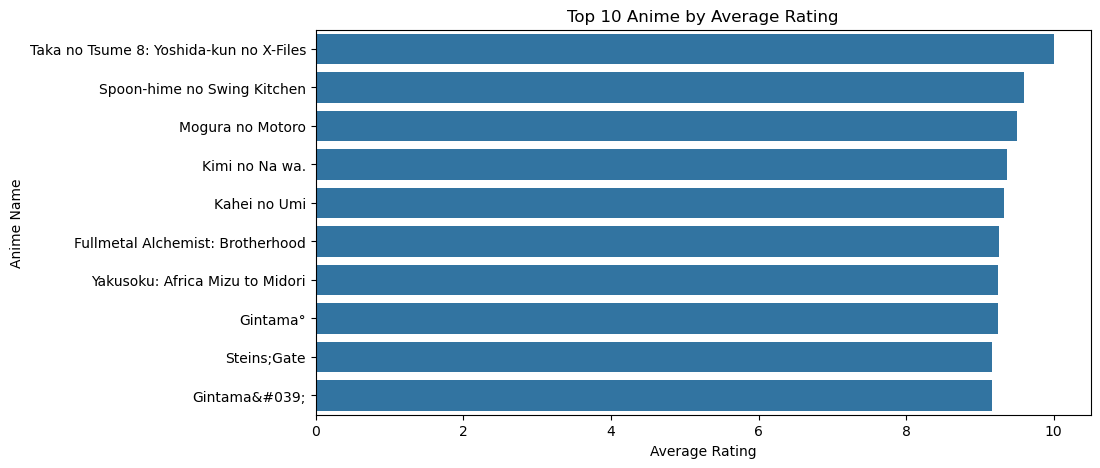

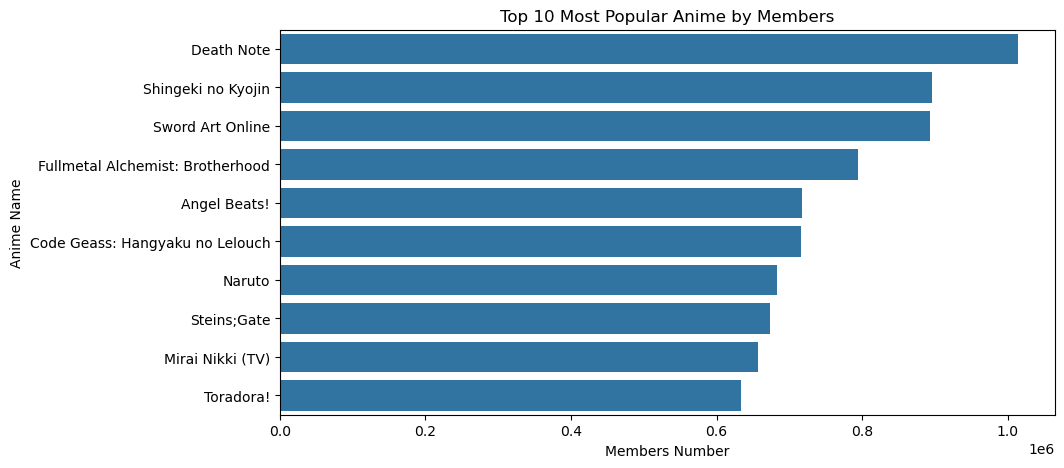

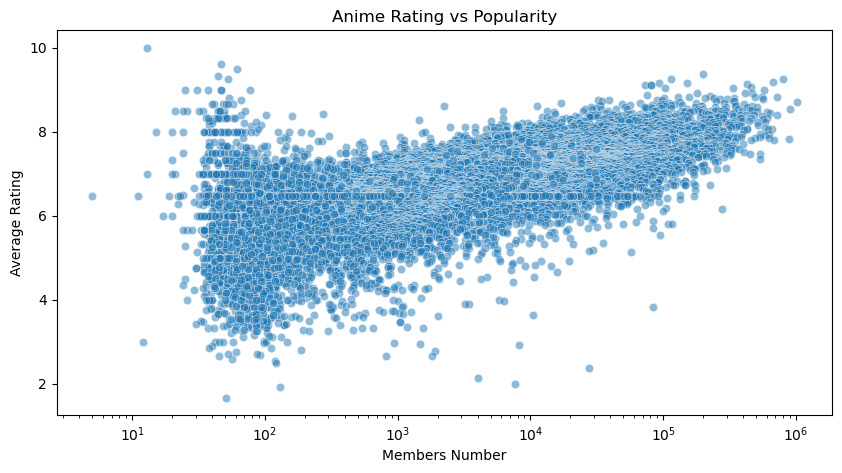

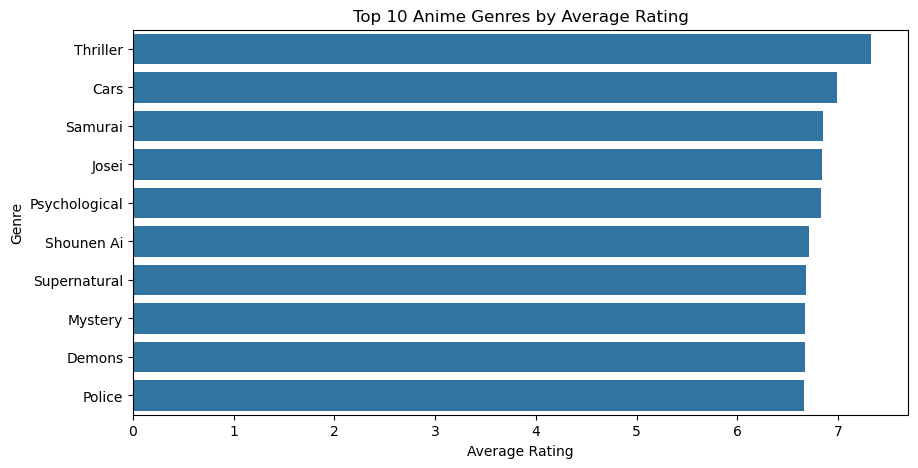

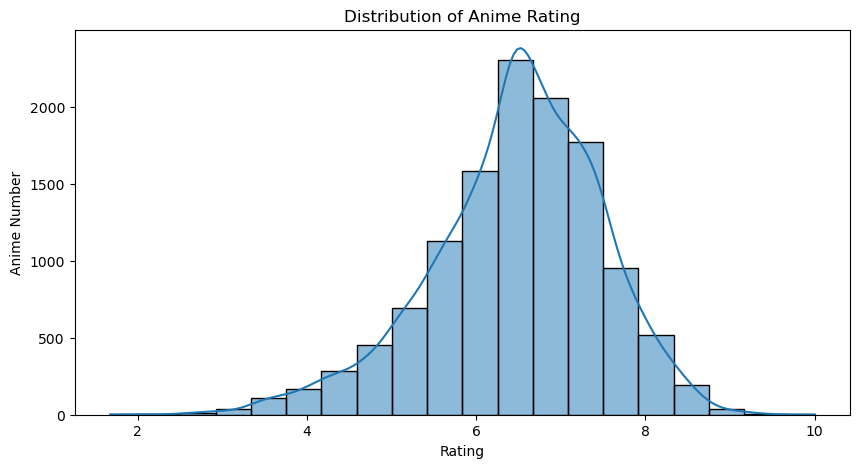

In [40]:
#EDA to visualise the data correlation
import seaborn as sns
import matplotlib.pyplot as plt

#top anime by average rating
top_rated = anime.sort_values(by='rating',ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x='rating',y='name',data=top_rated)
plt.title('Top 10 Anime by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Anime Name')
plt.show()

#most popular anime by number of members
top_members = anime.sort_values(by='members',ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x='members',y='name',data=top_members)
plt.title('Top 10 Most Popular Anime by Members')
plt.xlabel('Members Number')
plt.ylabel('Anime Name')
plt.show()

#popularity vs ratings
plt.figure(figsize=(10,5))
sns.scatterplot(x='members',y='rating', data=anime, alpha=0.5)
plt.xscale('log')
plt.title('Anime Rating vs Popularity')
plt.xlabel('Members Number')
plt.ylabel('Average Rating')
plt.show()

#top anime genre by average rating
df_genre = anime.copy()
df_genre = df_genre.assign(genre=anime['genre'].str.split(',').explode('genre'))
df_genre['genre'] = df_genre['genre'].str.strip()

top_genres = df_genre.groupby('genre')['rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_genres.values,y=top_genres.index)
plt.title('Top 10 Anime Genres by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

#distribution of ratings
plt.figure(figsize=(10,5))
sns.histplot(anime['rating'],bins=20,kde=True)
plt.title('Distribution of Anime Rating')
plt.xlabel('Rating')
plt.ylabel('Anime Number')
plt.show()

In [41]:
#Recommender system - Collaborative filtering(SVD)
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

#interpret rating (scale 1-10)
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(rating[['user_id','anime_id','rating']],reader)


#train and evaluate the SVD model
#set latent factors=50, training iteration number=15, fix the seed for random number generator=45
#verbose to show training progress
svd = SVD(n_factors=50, n_epochs=15, random_state=45, verbose=True)
#evaluate metric using 3-fold cross-validation
results = cross_validate(svd,data,measures=['RMSE','MAE'],cv=3,verbose=True)

#compute and print average results in 4 decimal places
print("\n----Model Evaluation----")
print(f"Average RMSE:{np.mean(results['test_rmse']):.4f}")
print(f"Average MAE:{np.mean(results['test_mae']):.4f}")


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)   

In [42]:
#Recommendation sample
#convert dataset for cross-validation into trainset using the build_full_trainset method
trainset = data.build_full_trainset()
#train the model on the dataset using the fit method
svd.fit(trainset)

#randomly pick a user
uid = rating.sample(1)['user_id'].iloc[0]

#identify anime the chosen user has not watched yet
watched_anime = rating.loc[rating['user_id'] == uid, 'anime_id']
not_watched = anime[~anime['anime_id'].isin(watched_anime)]

#predict the user's rating for those unseen anime 
preds = [svd.predict(uid,aid) for aid in not_watched['anime_id']]

#store anime IDs and predicted ratings in a DataFrame for later processing
pred_df = pd.DataFrame([(p.iid,p.est) for p in preds],columns=['anime_id','pred_rating'])

#top 10 recommendations for the selected user
pred_df['user_id'] = uid
top10 = pred_df.merge(anime, on='anime_id').sort_values('pred_rating',ascending=False).head(10)
#Round up to 2 decimal places
top10['pred_rating'] = top10['pred_rating'].round(2)
top10[['user_id','name','pred_rating','genre','rating']].head(10)
                       

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14


,user_id,name,pred_rating,genre,rating
5,2937,Ginga Eiyuu Densetsu,9.91,"Drama, Military, Sci-Fi, Space",9.11
3,2937,Gintama&#039;,9.47,"Action, Comedy, Historical, Parody, Samurai, S...",9.16
1,2937,Fullmetal Alchemist: Brotherhood,9.46,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.26
2,2937,Gintama°,9.41,"Action, Comedy, Historical, Parody, Samurai, S...",9.25
13,2937,Mushishi Zoku Shou 2nd Season,9.32,"Adventure, Fantasy, Historical, Mystery, Seine...",8.88
20,2937,Mushishi,9.29,"Adventure, Fantasy, Historical, Mystery, Seine...",8.78
9,2937,Gintama,9.28,"Action, Comedy, Historical, Parody, Samurai, S...",9.04
47,2937,Hellsing Ultimate,9.24,"Action, Horror, Military, Seinen, Supernatural...",8.59
7,2937,Gintama&#039;: Enchousen,9.24,"Action, Comedy, Historical, Parody, Samurai, S...",9.11
15,2937,Hajime no Ippo,9.20,"Comedy, Drama, Shounen, Sports",8.83


In [43]:
#PageRank library import
!pip install scikit-network
from IPython.display import SVG
from sknetwork.ranking import PageRank
from sknetwork.visualization import visualize_bigraph
from scipy import sparse


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [44]:
#PageRank - BiGraph preparation
#nodes: users and anime
#edges: user rated anime(weight = rating value)
#convert both ids to categorical codes to use these as indices in a matrix
user_ids = rating['user_id'].astype('category').cat.codes
anime_ids = rating['anime_id'].astype('category').cat.codes
#extract indices and weights as arrays
rows = user_ids.values
cols = anime_ids.values
weights = rating['rating'].values
#extract total number of uniques users and anime
n_users = len(np.unique(rows))
n_anime = len(np.unique(cols))

#store the connection in a sparse adjacency matrix
adjacency = sparse.csr_matrix((weights,(rows,cols)),shape=(n_users,n_anime))
#view the shape of adjacency matrix
print(f"Adjacency matrix shape: {adjacency.shape}")


Adjacency matrix shape: (69600, 9927)


In [45]:
#Fit PageRank in bigraph
#initialize PageRank algorithm
pagerank = PageRank()
#fit to the transpose of the adjacency matrix
scores = pagerank.fit_predict(adjacency.T)

#store the pagerank score and the corresponding anime IDs in a DataFrame
pr_anime = pd.DataFrame({'anime_id':rating['anime_id'].astype('category').cat.categories,
                        'pagerank':scores})

#Join the DataFrame with anime dataset to get all the necessary information, such as anime name, genre, and rating
pr_anime = pr_anime.merge(anime, on='anime_id',how='left')

#Top 10 anime (pagerank)
top_10 = pr_anime.sort_values('pagerank',ascending=False).head(10)
display(top_10[['anime_id','name','pagerank','genre','rating','members']])


,anime_id,name,pagerank,genre,rating,members
1388,1535,Death Note,0.002547,"Mystery, Police, Psychological, Supernatural, ...",8.71,1013917.0
1426,1575,Code Geass: Hangyaku no Lelouch,0.001827,"Action, Mecha, Military, School, Sci-Fi, Super...",8.83,715151.0
7059,16498,Shingeki no Kyojin,0.001826,"Action, Drama, Fantasy, Shounen, Super Power",8.54,896229.0
6323,11757,Sword Art Online,0.001757,"Action, Adventure, Fantasy, Game, Romance",7.83,893100.0
4567,6547,Angel Beats!,0.001685,"Action, Comedy, Drama, School, Supernatural",8.39,717796.0
3936,5114,Fullmetal Alchemist: Brotherhood,0.001678,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.26,793665.0
201,226,Elfen Lied,0.001638,"Action, Drama, Horror, Psychological, Romance,...",7.85,623511.0
2642,2904,Code Geass: Hangyaku no Lelouch R2,0.001623,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",8.98,572888.0
175,199,Sen to Chihiro no Kamikakushi,0.001571,"Adventure, Drama, Supernatural",8.93,466254.0
99,121,Fullmetal Alchemist,0.001565,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",8.33,600384.0


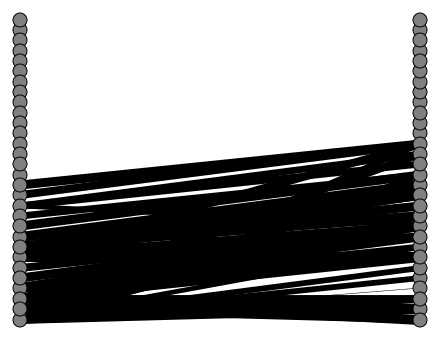

In [46]:
#Bigraph visualization
#take a subset of the adjacency matrix - first 30users and 30anime
adj_graph = adjacency[:30,:30]
#use built-in function to plot bipartite graph
image = visualize_bigraph(adj_graph,names_row=None,names_col=None)
#display the visualization as an SVG
SVG(image)


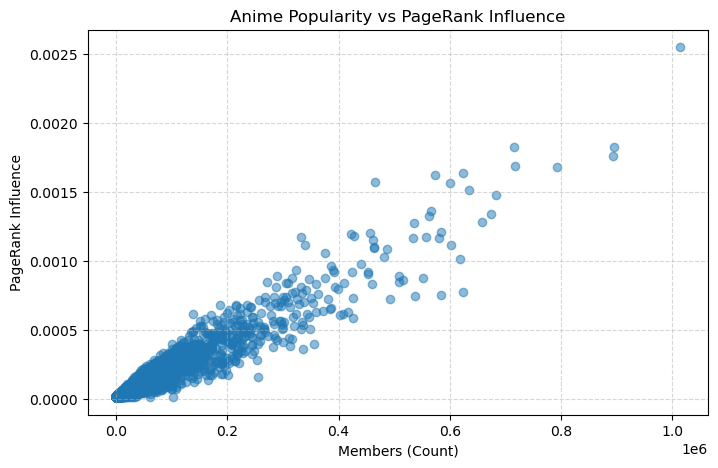

In [47]:
#Data Visualization for anime popularity vs PageRank influence
x = pr_anime['members']
y = pr_anime['pagerank']

plt.figure(figsize=(8,5))
#scatterplot, alpha=0.5 to adjust the points' opacity, useful for overlapping points 
plt.scatter(x,y,alpha=0.5)
plt.xlabel("Members (Count)")
plt.ylabel("PageRank Influence")
plt.title("Anime Popularity vs PageRank Influence")
plt.grid(True, linestyle='--',alpha=0.5)
plt.show()

In [48]:
#convert the existing adjacency matrix to networkX bigraph
import networkx as nx

#create a new empty graph
E = nx.Graph()

#add user and anime nodes
user_nodes = ['U_' + str(i) for i in range(adjacency.shape[0])]
anime_nodes = ['A_' + str(i) for i in range(adjacency.shape[1])]

#add user nodes to graph and assign them to bipartite set 0 and 1 respectively
E.add_nodes_from(user_nodes, bipartite=0)
E.add_nodes_from(anime_nodes, bipartite=1)

#find non-zero entries in adjacency matrix
rows, cols = adjacency.nonzero() 
#convert to 1D array
weights = adjacency[rows,cols].A1

#loop through all user-anime pairs with ratings
#add edges as the edge weight
for r, c, w in zip(rows, cols, weights):
    E.add_edge('U_'+str(r), 'A_'+str(c), weight=w)


In [49]:
#import Louvain community detection
from networkx.algorithms.community import louvain_communities

#detect communities on the bigraph
communities = louvain_communities(E, weight='weight')
#display the number of detected communities
print(f'Detected {len(communities)} community')


Detected 6 community


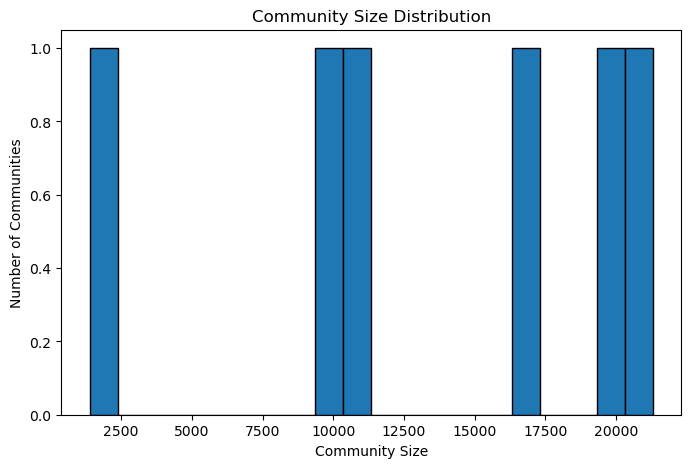

In [50]:
#plot the graph for community size distribution
#calculate the size of each detected community
community_size = [len(c) for c in communities]

plt.figure(figsize=(8,5))
plt.hist(community_size, bins=20, edgecolor='Black')
plt.xlabel('Community Size')
plt.ylabel('Number of Communities')
plt.title('Community Size Distribution')
plt.show()


In [51]:
#This code is to find out the pagerank of an anime
#Ensure the DataFrame is sorted descending
pr_anime_sorted = pr_anime.sort_values('pagerank',ascending=False).reset_index(drop=True)

#Define a function to check ranking of anime
def check_rank(name):
    #find all rows containing the name
    rows_anime = pr_anime_sorted[pr_anime_sorted['name'].str.contains(name,case=False,na=False)]
    #at least one match is found
    if not rows_anime.empty:
        for idx, row in rows_anime.iterrows():
            rank = row.name + 1
            print(f"Rank #{rank}: {row['name']} - PageRank score {row['pagerank']}")
    else:
        #no matching anime found
        print(f"No anime found '{name}'.")

#Example usage: check ranking of "naruto"
check_rank("naruto")

Rank #12: Naruto - PageRank score 0.0014789511414289118
Rank #235: Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo! - PageRank score 0.00041512615324797685
Rank #288: Naruto: Shippuuden Movie 1 - PageRank score 0.0003720288716407993
Rank #344: Naruto Movie 2: Dai Gekitotsu! Maboroshi no Chiteiiseki Dattebayo! - PageRank score 0.0003244841143672785
Rank #345: Naruto: Shippuuden Movie 2 - Kizuna - PageRank score 0.00032415368119170925
Rank #389: Naruto Movie 3: Dai Koufun! Mikazuki Jima no Animaru Panikku Dattebayo! - PageRank score 0.0003001481540027709
Rank #464: Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono - PageRank score 0.000268121550639026
Rank #503: Naruto: Shippuuden Movie 4 - The Lost Tower - PageRank score 0.0002570398436750526
Rank #527: Naruto: Shippuuden Movie 6 - Road to Ninja - PageRank score 0.0002452826281198658
Rank #591: Naruto: Shippuuden Movie 5 - Blood Prison - PageRank score 0.00022202101562265823
Rank #677: Naruto: Takigakure no Shitou